# 📝 Exercise M6.04

The aim of the exercise is to get familiar with the histogram
gradient-boosting in scikit-learn. Besides, we will use this model within
a cross-validation framework in order to inspect internal parameters found
via grid-search.

We will use the California housing dataset.

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

First, create a histogram gradient boosting regressor. You can set the
trees number to be large, and configure the model to use early-stopping.

In [2]:
# Write your code here.

# solution
from sklearn.ensemble import HistGradientBoostingRegressor

hist_gbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=0)

We will use a grid-search to find some optimal parameter for this model.
In this grid-search, you should search for the following parameters:

* `max_depth: [3, 8]`;
* `max_leaf_nodes: [15, 31]`;
* `learning_rate: [0.1, 1]`.

Feel free to explore the space with additional values. Create the
grid-search providing the previous gradient boosting instance as the model.

In [3]:
# Write your code here.

# solution
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth": [3, 8],
    "max_leaf_nodes": [15, 31],
    "learning_rate": [0.1, 1],
}

search = GridSearchCV(hist_gbdt, params)

Finally, we will run our experiment through cross-validation. In this regard,
define a 5-fold cross-validation. Besides, be sure to shuffle the data.
Subsequently, use the function `sklearn.model_selection.cross_validate`
to run the cross-validation. You should also set `return_estimator=True`,
so that we can investigate the inner model trained via cross-validation.

In [4]:
# Write your code here.

# solution
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)
results = cross_validate(
    search, data, target, cv=cv, return_estimator=True, n_jobs=2)

Now that we got the cross-validation results, print out the mean and
standard deviation score.

In [5]:
# Write your code here.

# solution
print(f"R2 score with cross-validation:\n"
      f"{results['test_score'].mean():.3f} +/- "
      f"{results['test_score'].std():.3f}")

R2 score with cross-validation:
0.839 +/- 0.006


Then inspect the `estimator` entry of the results and check the best
parameters values. Besides, check the number of trees used by the model.

In [6]:
# Write your code here.

# solution
for estimator in results["estimator"]:
    print(estimator.best_params_)
    print(f"# trees: {estimator.best_estimator_.n_iter_}")

{'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 15}
# trees: 528
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 447
{'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 15}
# trees: 576
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 290
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 414


Inspect the results of the inner CV for each estimator of the outer CV.
Aggregate the mean test score for each parameter combination and make a box
plot of these scores.

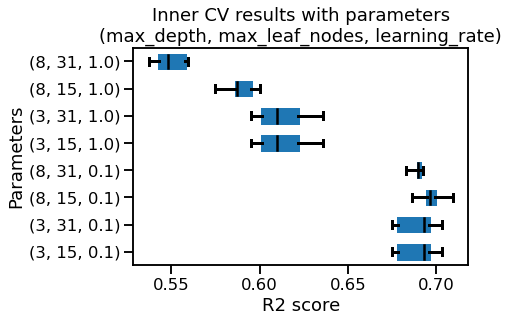

In [7]:
# Write your code here.

# solution
import pandas as pd

index_columns = [f"param_{name}" for name in params.keys()]
columns = index_columns + ["mean_test_score"]

inner_cv_results = []
for cv_idx, estimator in enumerate(results["estimator"]):
    search_cv_results = pd.DataFrame(estimator.cv_results_)
    search_cv_results = search_cv_results[columns].set_index(index_columns)
    search_cv_results = search_cv_results.rename(
        columns={"mean_test_score": f"CV {cv_idx}"})
    inner_cv_results.append(search_cv_results)
inner_cv_results = pd.concat(inner_cv_results, axis=1).T

import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel("R2 score")
plt.ylabel("Parameters")
_ = plt.title("Inner CV results with parameters\n"
              "(max_depth, max_leaf_nodes, learning_rate)")